# Clustering

In [24]:
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

## Preprocessing

In [25]:
df = pd.read_csv("./../../data/goodreads_data.csv", converters={"genres": lambda x: x[1:-1].split(",")})
df["publication_date"] = pd.to_datetime(df["published"].apply(lambda x: " ".join(str(x).split()[:3])), errors="coerce")
df["publication_year"] = df["publication_date"].dt.year.astype("float")
df["n_pages"] = df["pages_format"].apply(lambda x: int(x.split()[0]) if x.split()[0].isdigit() else np.nan).astype("float")
df["format"] = df["pages_format"].apply(lambda x: x.replace("Kindle Edition", "Kindle").split()[-1].lower() if x.replace("Kindle Edition", "Kindle").split()[-1].lower() in ["hardcover", "paperback", "ebook", "audiobook", "audio", "cd", "kindle"] else "other").astype("category")

dic_rating = {1: "one_star", 2: "two_stars", 3: "three_stars", 4: "four_stars", 5: "five_stars"}
for key, value in dic_rating.items():
    df[value] = df["ratings"].apply(lambda x: float(x[1:-1].split(",")[key-1])) / df["n_ratings"]
df["average_rating"] = df["ratings"].apply(lambda x: sum([(i+1) * float(x[1:-1].split(",")[i]) for i in range(5)])) / df["n_ratings"]

df.head(5)

,title,author,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
0,The Weed That Strings the Hangman's Bag,Alan Bradley,4.99,From Dagger Award-winning and internationally ...,Librarian Note: There is more than one author ...,"['Mystery', 'Fiction', 'Historical Fiction',...",55692.0,5756.0,"[395.0, 1540.0, 12237.0, 25714.0, 15806.0]","364 pages, Hardcover",...,NaN,2010-03-09,2010.0,364.0,0.007093,0.027652,0.219726,0.461718,0.283811,3.987503
1,A Good Man in Africa,William Boyd,11.99,"In the small African republic of Kinjanja, Bri...","Note: William^^BoydOf Scottish descent, Boyd w...","['Fiction', 'Africa', 'Humor', 'Novels', '...",5018.0,298.0,"[90.0, 257.0, 1222.0, 2184.0, 1265.0]","352 pages, Paperback",...,['Kinjanja'],2003-01-14,2003.0,352.0,0.017935,0.051216,0.243523,0.435233,0.252092,3.852332
2,It Had to Be You,Janice Thompson,0.00,Bella couldn't be happier that her long-feudin...,"Welcome to the wacky, wonderful world of inspi...","['Christian Fiction', 'Romance', 'Christian'...",2152.0,132.0,"[14.0, 86.0, 421.0, 735.0, 896.0]","336 pages, Paperback",...,"['Galveston, Texas']",2010-05-01,2010.0,336.0,0.006506,0.039963,0.195632,0.341543,0.416357,4.121283
3,Missing,Kelley Armstrong,6.99,Everyone knows they left. No one knows they're...,Kelley Armstrong has been telling stories sinc...,"['Young Adult', 'Mystery', 'Thriller', 'Fic...",3393.0,491.0,"[54.0, 185.0, 799.0, 1308.0, 1047.0]","515 pages, ebook",...,NaN,2017-04-18,2017.0,515.0,0.015915,0.054524,0.235485,0.385500,0.308576,3.916298
4,Dawn of Rebellion,Michelle Lynn,0.00,"My name is Dawn Nolan, and I've grown up on th...",Michelle moved around the Midwest most of her ...,"['Young Adult', 'Dystopia', 'Romance', 'Sci...",142.0,76.0,"[1.0, 6.0, 23.0, 41.0, 71.0]","321 pages, Paperback",...,NaN,2013-10-17,2013.0,321.0,0.007042,0.042254,0.161972,0.288732,0.500000,4.232394


In [26]:
print("Number of books (with duplicates): ", len(df))
df.drop_duplicates(subset=["title", "author"], keep='first', inplace=True, ignore_index=True)
print("Number of books (without duplicates): ", len(df))

Number of books (with duplicates):  24630
Number of books (without duplicates):  19666


## Encoding the Qualitative Features

In [27]:
df_genres = df.explode("genres")
df_genres["genres"] = df_genres["genres"].apply(lambda x: x.strip()[1:-1]) 
df_genres["genres"].astype("category")
df_genres = df_genres[df_genres["genres"] != "...more"]

genres_groups = df_genres.groupby("genres")
genres_number_of_books = genres_groups.count().sort_values(by="title", ascending=False)
most_popular_genres = genres_number_of_books.head(20).index.tolist()

df["genres"] = df["genres"].apply(lambda x: list(set([genre.strip()[1:-1] if genre.strip()[1:-1] in most_popular_genres else "OtherGenres" for genre in x])))
df = df[df["genres"].map(len) > 0]

In [28]:
df_clustering = df[["price", "publication_year", "n_pages"]]
df_clustering = (df_clustering - df_clustering.mean()) / df_clustering.std()

In [29]:
mlb = MultiLabelBinarizer()
df_genres_one_hot = pd.DataFrame(mlb.fit_transform(df["genres"]), columns=mlb.classes_, index=df.index)

lb = LabelBinarizer()
df_format_one_hot = pd.DataFrame(lb.fit_transform(df["format"]), columns=lb.classes_, index=df.index)

In [30]:
df_clustering = pd.concat([df_clustering, df_genres_one_hot, df_format_one_hot], axis=1)
df_clustering = df_clustering.dropna()
df_clustering.head(5)

,price,publication_year,n_pages,Adult,Adventure,Audiobook,Biography,Classics,Contemporary,Contemporary Romance,...,Thriller,Young Adult,audio,audiobook,cd,ebook,hardcover,kindle,other,paperback
0,-0.418172,0.179883,0.162318,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.654207,-0.487601,0.109364,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.182625,0.179883,0.038760,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.111778,0.847367,0.828646,0,0,0,0,0,1,0,...,1,1,0,0,0,1,0,0,0,0
4,-1.182625,0.465947,-0.027432,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## PCA

In [31]:
# No missing value
assert(df_clustering.isna().sum().all() == 0)
# Only numeric values
assert(df_clustering.shape[1] == df_clustering.select_dtypes(include=np.number).shape[1])

In [32]:
pca = PCA()
pca = pca.fit(df_clustering)

In [33]:
cols = ['Sing. Value', 'Variance', 'Ratio', 'Cum. Sum']
cum_sum = np.array([pca.explained_variance_ratio_[:i+1].sum() for i in range(len(pca.explained_variance_ratio_))])
summary = np.array([pca.singular_values_, pca.explained_variance_, pca.explained_variance_ratio_, cum_sum]).T
df_var = pd.DataFrame(summary, columns=cols)
df_var.head(5)

,Sing. Value,Variance,Ratio,Cum. Sum
0,160.309724,1.344663,0.221221,0.221221
1,141.410236,1.046298,0.172135,0.393356
2,125.008305,0.817658,0.134519,0.527875
3,97.491634,0.497312,0.081817,0.609692
4,80.952679,0.342891,0.056412,0.666103


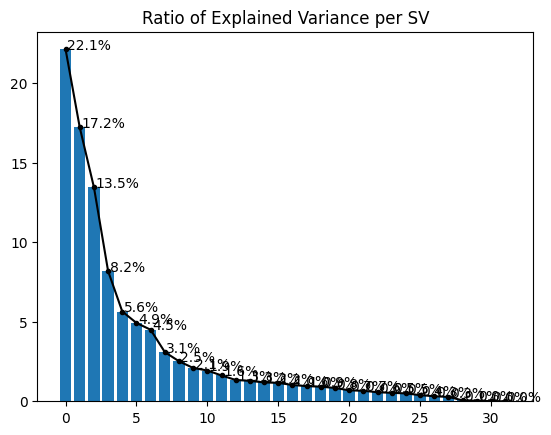

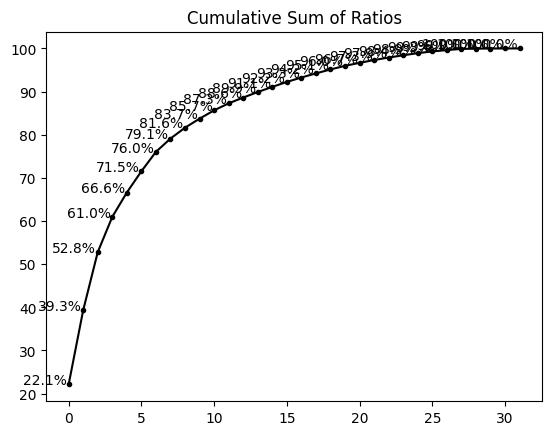

In [34]:
plt.figure()
x_axis = np.arange(0, len(pca.explained_variance_ratio_))
plt.bar(x_axis, height=pca.explained_variance_ratio_*100)
plt.plot(x_axis, pca.explained_variance_ratio_*100, marker='.', color='black')
for i in range(len(x_axis)):
    plt.text(x_axis[i] + 0.1, pca.explained_variance_ratio_[i]*100, f'{pca.explained_variance_ratio_[i]*100:.1f}%', horizontalalignment="left")
plt.title('Ratio of Explained Variance per SV')
plt.show()

plt.figure()
x2_axis = np.arange(0, len(cum_sum))
plt.plot(x2_axis, cum_sum*100, marker='.', color='black')
for i in range(len(x2_axis)):
    plt.text(x2_axis[i] - 0.1, cum_sum[i]*100, f'{cum_sum[i]*100:.1f}%', horizontalalignment="right")
plt.title('Cumulative Sum of Ratios')
plt.show()

In [35]:
n_components = 0
for i in range(len(cum_sum)):
    if cum_sum[i] >= 0.90:
        n_components = i+1
        break

print(f"Number of components to explain 90% of the variance: {n_components}")

Number of components to explain 90% of the variance: 15


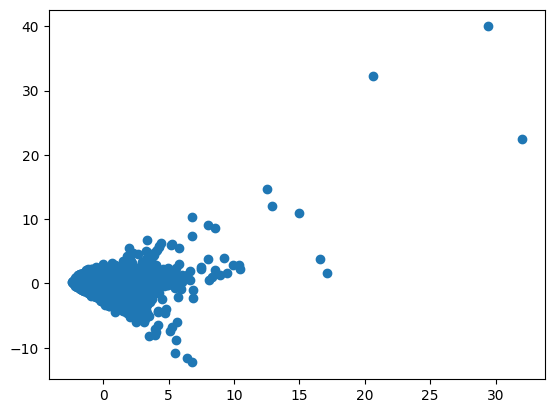

In [36]:
pca_data = pca.transform(df_clustering)
plt.scatter(pca_data[:,0], pca_data[:,1])
plt.show()

## Clustering Algorithms

In [14]:
tab20 = plt.get_cmap('tab20')

scores = {
    "DBSCAN": {"Silhouette": [], "Davies-Bouldin": []},
    "KMeans": {"Silhouette": [], "Davies-Bouldin": []},
    "GaussianMixture": {"Silhouette": [], "Davies-Bouldin": []},
    "Isomap": {"Silhouette": [], "Davies-Bouldin": []},
    "TSNE": {"Silhouette": [], "Davies-Bouldin": []}
}

### Density-Based Clustering

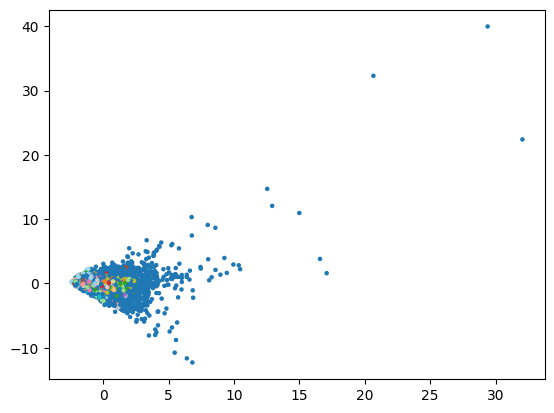

In [130]:
dbscan = DBSCAN()
pred = dbscan.fit_predict(pca_data)
color = [tab20.colors[(pred[i]+1)%20] for i in range(len(pred))]

scores["DBSCAN"]["Silhouette"].append(silhouette_score(pca_data, pred))
scores["DBSCAN"]["Davies-Bouldin"].append(davies_bouldin_score(pca_data, pred))

plt.scatter(pca_data[:,0], pca_data[:,1], c=color, s=5)
plt.show()

In [131]:
print("Number of components: ", dbscan.labels_.max())

Number of components:  339


### KMeans

In [132]:
n_max_clusters = 345

In [133]:
inertias = []
silhouettes = []
for k in range(330, n_max_clusters+1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_data)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(pca_data, kmeans.labels_))

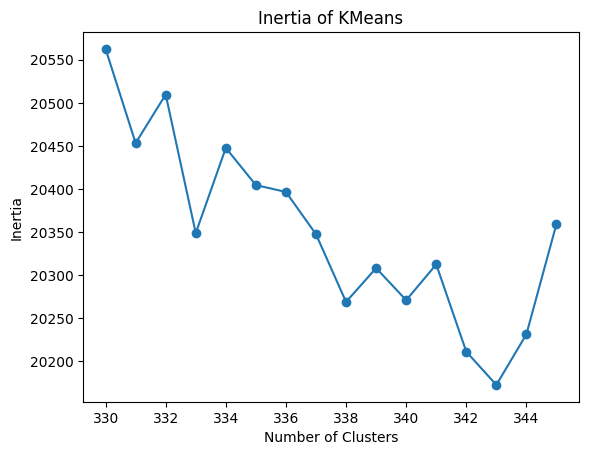

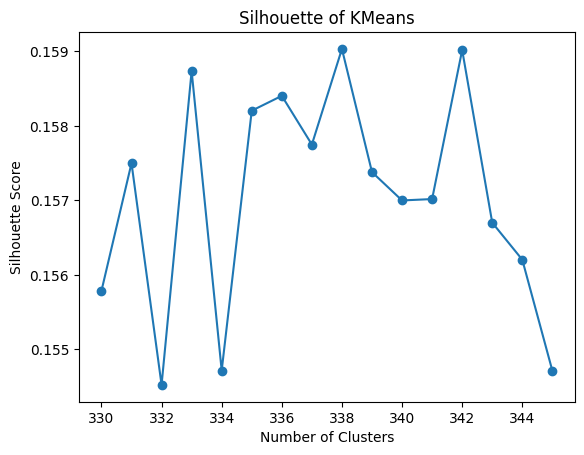

In [134]:
plt.plot(range(330, n_max_clusters+1), inertias, marker='o')
plt.title("Inertia of KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

plt.plot(range(330, n_max_clusters+1), silhouettes, marker='o')
plt.title("Silhouette of KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

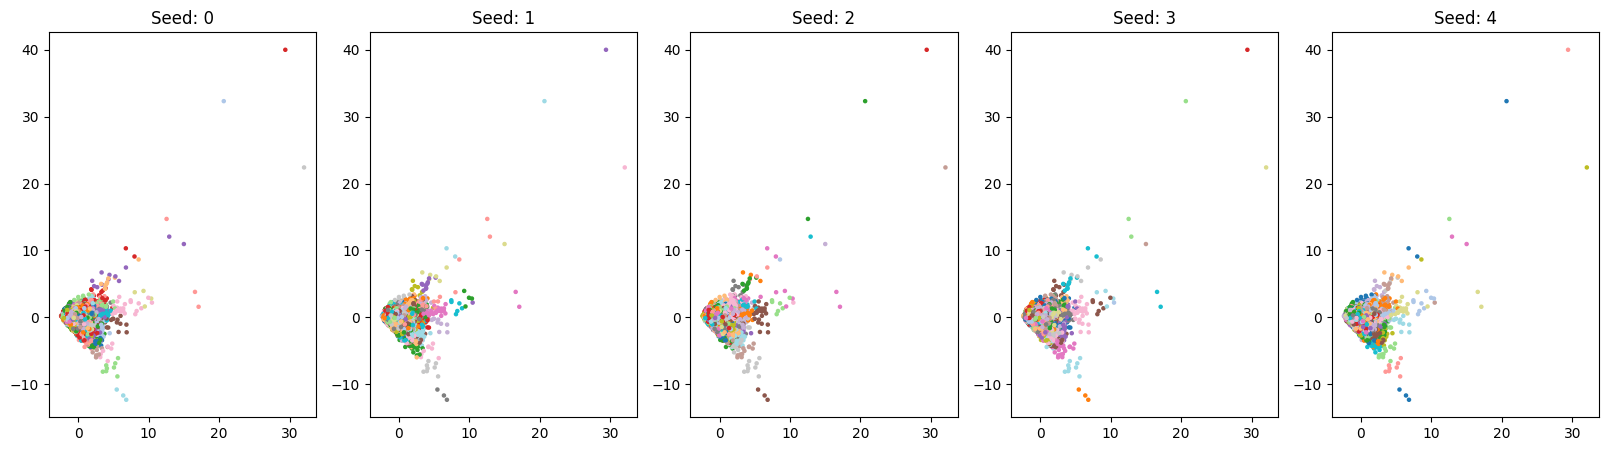

In [135]:
plt.subplots(1, 5, figsize=(20, 5))
for seed in range(0, 5):
    kmeans = KMeans(n_clusters=339, random_state=seed)
    pred = kmeans.fit_predict(pca_data)
    color = [tab20.colors[pred[i]%20] for i in range(len(pred))]

    scores["KMeans"]["Silhouette"].append(silhouette_score(pca_data, pred))
    scores["KMeans"]["Davies-Bouldin"].append(davies_bouldin_score(pca_data, pred))

    plt.subplot(1, 5, seed+1)
    plt.title(f"Seed: {seed}")
    plt.scatter(pca_data[:,0], pca_data[:,1], c=color, s=5)
plt.show()

### Gaussian Mixture

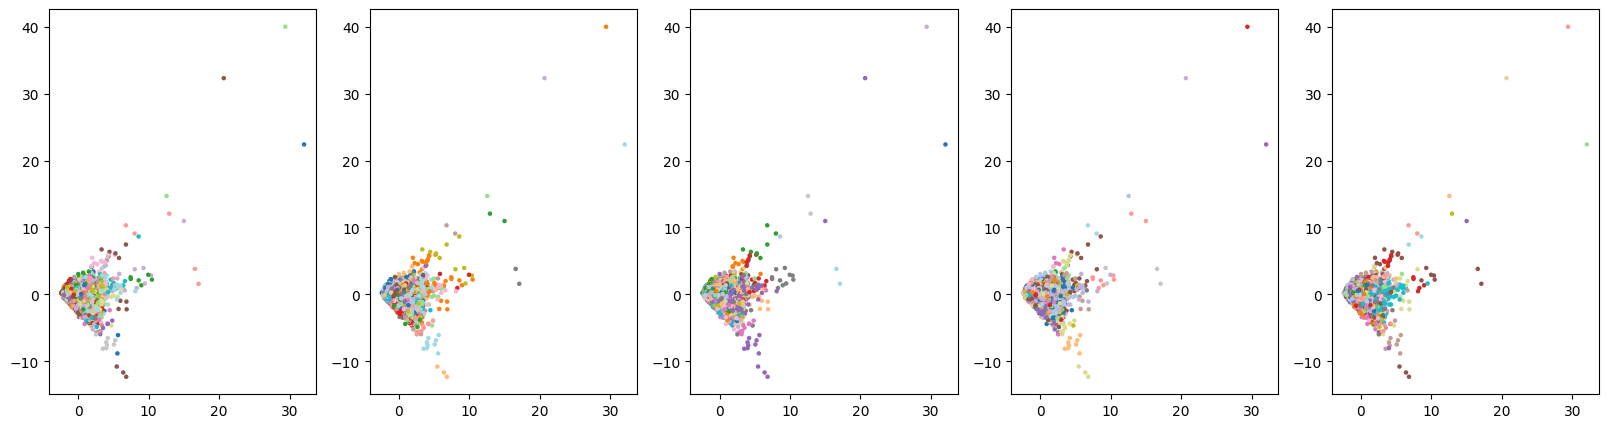

In [136]:
plt.subplots(1, 5, figsize=(20, 5))

for seed in range(5, 10):
    gmm = GaussianMixture(n_components=339, random_state=seed)
    pred = gmm.fit_predict(pca_data)
    color = [tab20.colors[pred[i]%20] for i in range(len(pca_data))]

    scores["GaussianMixture"]["Silhouette"].append(silhouette_score(pca_data, pred))
    scores["GaussianMixture"]["Davies-Bouldin"].append(davies_bouldin_score(pca_data, pred))

    plt.subplot(1, 5, seed-4)
    plt.scatter(pca_data[:,0], pca_data[:,1], c=color, s=5)
plt.show()

### Isomap

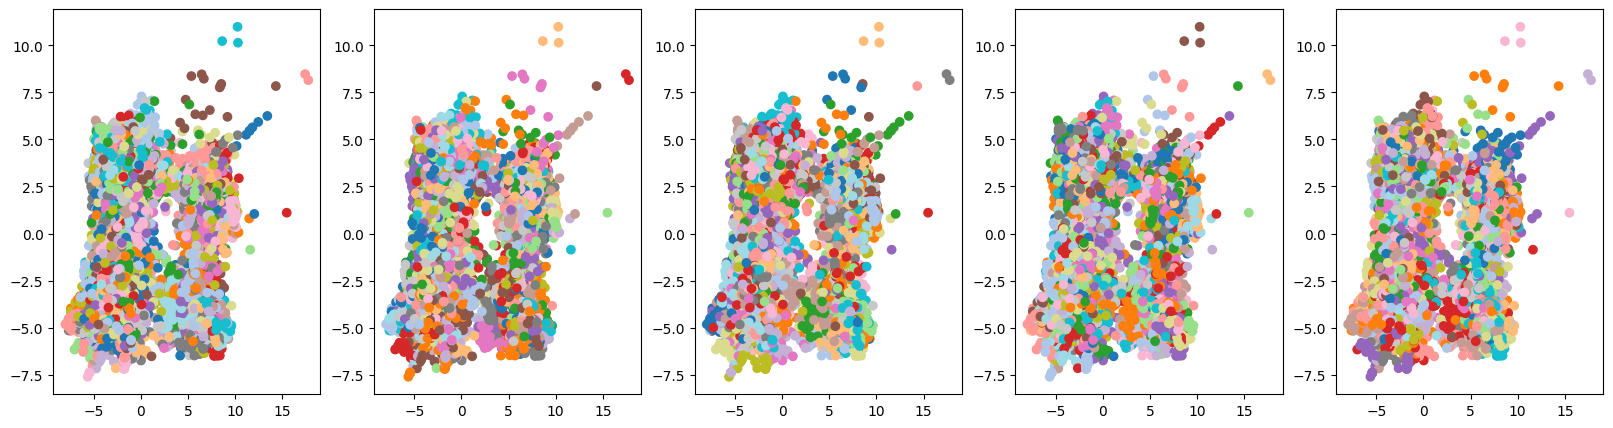

In [137]:
with warnings.catch_warnings(action="ignore"):
    isomap = Isomap()
    isomap_data = isomap.fit_transform(df_clustering)

    plt.subplots(1, 5, figsize=(20, 5))
    for seed in range(10, 15):
        km = KMeans(n_clusters=339)
        pred = km.fit_predict(df_clustering)
        color = [tab20.colors[pred[i]%20] for i in range(len(isomap_data))]

        scores["Isomap"]["Silhouette"].append(silhouette_score(isomap_data, pred))
        scores["Isomap"]["Davies-Bouldin"].append(davies_bouldin_score(isomap_data, pred))

        plt.subplot(1, 5, seed-9)
        plt.scatter(isomap_data[:,0], isomap_data[:,1], color=color)
    plt.show()

### TSNE

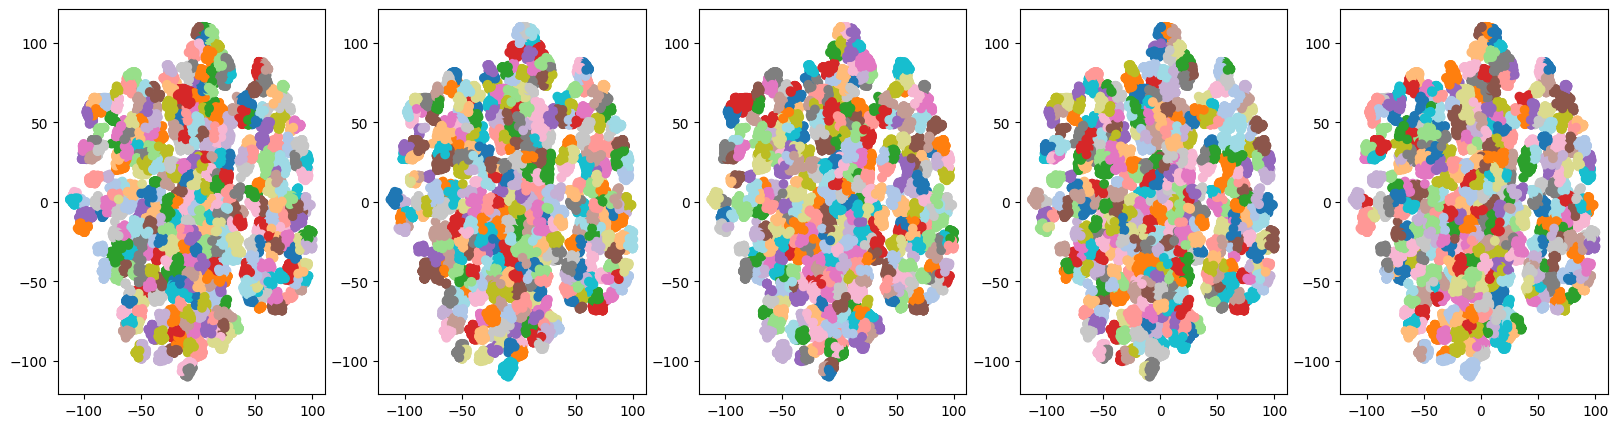

In [138]:
tsne = TSNE()
tsne_data = tsne.fit_transform(df_clustering)

plt.subplots(1, 5, figsize=(20, 5))
for seed in range(15, 20):
    km = KMeans(n_clusters=339, random_state=seed)
    pred = km.fit_predict(tsne_data)
    color = [tab20.colors[pred[i]%20] for i in range(len(tsne_data))]

    scores["TSNE"]["Silhouette"].append(silhouette_score(tsne_data, pred))
    scores["TSNE"]["Davies-Bouldin"].append(davies_bouldin_score(tsne_data, pred))

    plt.subplot(1, 5, seed-14)
    plt.scatter(tsne_data[:,0], tsne_data[:,1], color=color)
plt.show()

## Models Comparison

In [139]:
scores

{'DBSCAN': {'Silhouette': [-0.1508531773633573],
  'Davies-Bouldin': [1.4463342117238764]},
 'KMeans': {'Silhouette': [0.15787235383431042,
   0.15825008599807805,
   0.15656067056549047,
   0.15611486687084436,
   0.15251324110436826],
  'Davies-Bouldin': [1.6606087077037657,
   1.6308991728986721,
   1.629890829240075,
   1.6560446315953674,
   1.6413938343458636]},
 'GaussianMixture': {'Silhouette': [0.040718664659444063,
   0.0503573068436447,
   0.04135995327123552,
   0.040141723602173954,
   0.04521264325977987],
  'Davies-Bouldin': [2.3023378112643975,
   2.35658682313982,
   2.3190296543189195,
   2.2819162745003463,
   2.2622167812097134]},
 'Isomap': {'Silhouette': [-0.25342208212054507,
   -0.25945874428245214,
   -0.2598250432516637,
   -0.2508739406963604,
   -0.25602411100040084],
  'Davies-Bouldin': [12.3203030902411,
   12.89521759298033,
   11.326544963517753,
   13.773401588606268,
   12.858469639994759]},
 'TSNE': {'Silhouette': [0.45234388,
   0.4597044,
   0.46193

In [140]:
for algo, scores in scores.items():
    print(f"{algo}")
    for score, values in scores.items():
        print(f"\t{score}: {np.mean(values):.3f} +/- {np.std(values):.3f}")

DBSCAN
	Silhouette: -0.151 +/- 0.000
	Davies-Bouldin: 1.446 +/- 0.000
KMeans
	Silhouette: 0.156 +/- 0.002
	Davies-Bouldin: 1.644 +/- 0.013
GaussianMixture
	Silhouette: 0.044 +/- 0.004
	Davies-Bouldin: 2.304 +/- 0.032
Isomap
	Silhouette: -0.256 +/- 0.003
	Davies-Bouldin: 12.635 +/- 0.803
TSNE
	Silhouette: 0.457 +/- 0.004
	Davies-Bouldin: 0.746 +/- 0.010


In [145]:
scores

{'DBSCAN': {'Silhouette': [-0.1508531773633573],
  'Davies-Bouldin': [1.4463342117238764]},
 'KMeans': {'Silhouette': [0.15787235383431042,
   0.15825008599807805,
   0.15656067056549047,
   0.15611486687084436,
   0.15251324110436826],
  'Davies-Bouldin': [1.6606087077037657,
   1.6308991728986721,
   1.629890829240075,
   1.6560446315953674,
   1.6413938343458636]},
 'GaussianMixture': {'Silhouette': [0.040718664659444063,
   0.0503573068436447,
   0.04135995327123552,
   0.040141723602173954,
   0.04521264325977987],
  'Davies-Bouldin': [2.3023378112643975,
   2.35658682313982,
   2.3190296543189195,
   2.2819162745003463,
   2.2622167812097134]},
 'Isomap': {'Silhouette': [-0.25342208212054507,
   -0.25945874428245214,
   -0.2598250432516637,
   -0.2508739406963604,
   -0.25602411100040084],
  'Davies-Bouldin': [12.3203030902411,
   12.89521759298033,
   11.326544963517753,
   13.773401588606268,
   12.858469639994759]},
 'TSNE': {'Silhouette': [0.45234388,
   0.4597044,
   0.46193

In [146]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    for metric in scores[algo1].keys():
        t, p = ttest_ind(scores[algo1][metric], scores[algo2][metric])
        print(f"\t{metric}: p = {p:.5f}")

Comparing DBSCAN and KMeans
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00022
Comparing DBSCAN and GaussianMixture
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00003
Comparing DBSCAN and Isomap
	Silhouette: p = 0.00002
	Davies-Bouldin: p = 0.00034
Comparing DBSCAN and TSNE
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00000
Comparing KMeans and GaussianMixture
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00000
Comparing KMeans and Isomap
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00000
Comparing KMeans and TSNE
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00000
Comparing GaussianMixture and Isomap
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00000
Comparing GaussianMixture and TSNE
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00000
Comparing Isomap and TSNE
	Silhouette: p = 0.00000
	Davies-Bouldin: p = 0.00000


## Clusters Features with KMeans

In [50]:
kmeans = KMeans(n_clusters=339, random_state=0)
pred = kmeans.fit_predict(pca_data)
color = [tab20.colors[pred[i]%20] for i in range(len(pred))]

In [51]:
labels, counts = np.unique(pred, return_counts=True)
largest_clusters_desc_idx = np.argsort(-counts)
largest_clusters_centers_desc = kmeans.cluster_centers_[largest_clusters_desc_idx]

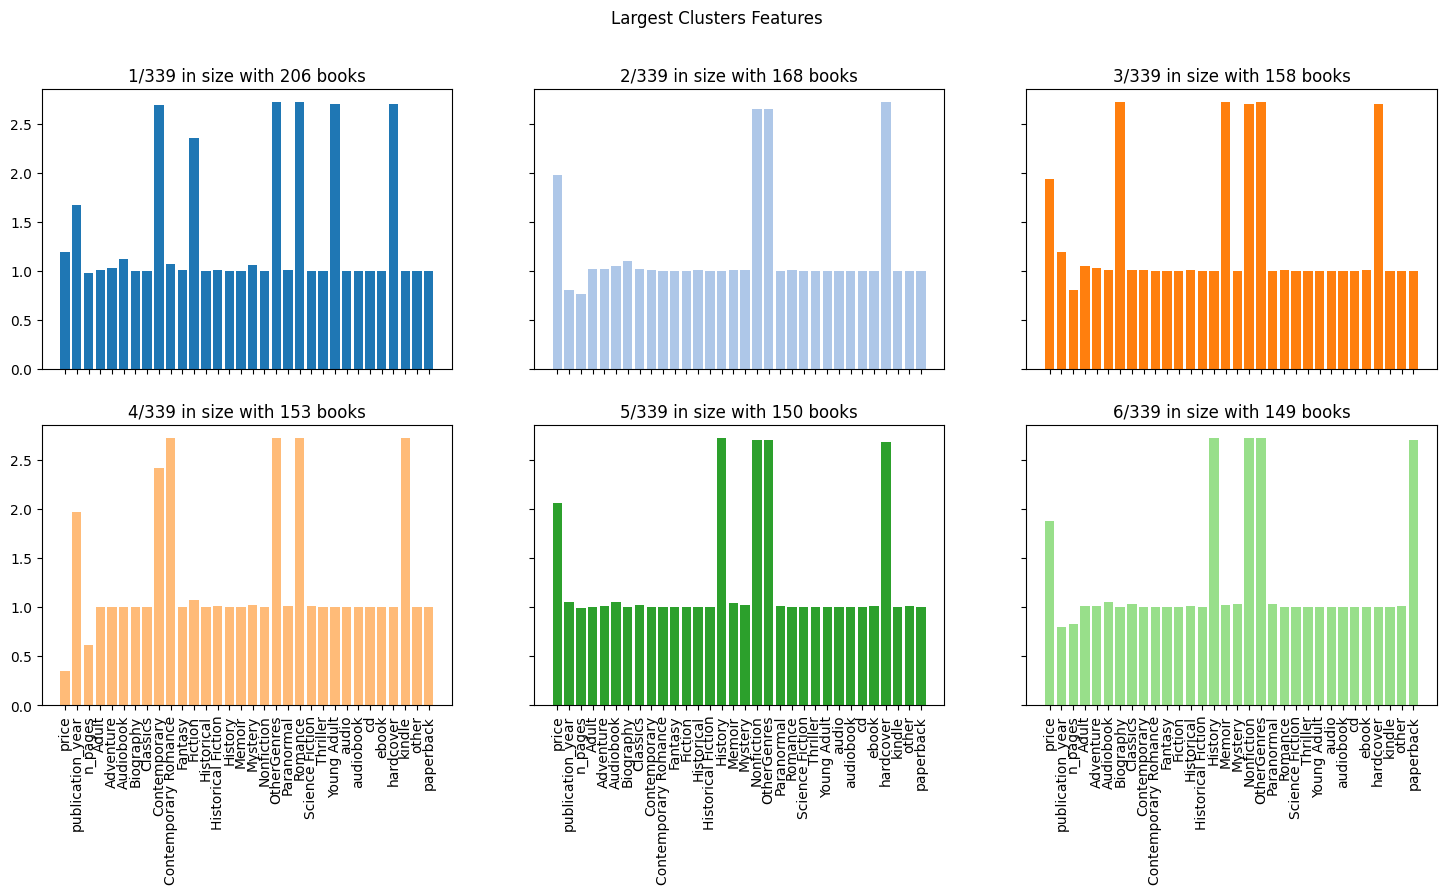

In [52]:
n_clusters = kmeans.n_clusters
real_largest_centers = np.exp(pca.inverse_transform(largest_clusters_centers_desc[:6]))
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(18, 8))
plt.suptitle("Largest Clusters Features")
for i, k in enumerate(real_largest_centers):
    cluster_n_books = df_clustering[pred == largest_clusters_desc_idx[i]].join(df.loc[df_clustering.index, ["title", "author", "average_rating"]], how="inner").shape[0]
    axs.flatten()[i].title.set_text(f"{i+1}/{n_clusters} in size with {cluster_n_books} books")
    axs.flatten()[i].bar(range(len(k)), k, color=tab20.colors[i%20])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(df_clustering.columns, rotation="vertical")
plt.show()